### Imports

In [1]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

from IPython.display import Audio

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [2]:
CREMA = "../input/speech-emotion-recognition-en/Crema/"

file_list = os.listdir(CREMA)
file_list.sort()

# Lists all files within the CREMA-D dataset
file_list

['1001_DFA_ANG_XX.wav',
 '1001_DFA_DIS_XX.wav',
 '1001_DFA_FEA_XX.wav',
 '1001_DFA_HAP_XX.wav',
 '1001_DFA_NEU_XX.wav',
 '1001_DFA_SAD_XX.wav',
 '1001_IEO_ANG_HI.wav',
 '1001_IEO_ANG_LO.wav',
 '1001_IEO_ANG_MD.wav',
 '1001_IEO_DIS_HI.wav',
 '1001_IEO_DIS_LO.wav',
 '1001_IEO_DIS_MD.wav',
 '1001_IEO_FEA_HI.wav',
 '1001_IEO_FEA_LO.wav',
 '1001_IEO_FEA_MD.wav',
 '1001_IEO_HAP_HI.wav',
 '1001_IEO_HAP_LO.wav',
 '1001_IEO_HAP_MD.wav',
 '1001_IEO_NEU_XX.wav',
 '1001_IEO_SAD_HI.wav',
 '1001_IEO_SAD_LO.wav',
 '1001_IEO_SAD_MD.wav',
 '1001_IOM_ANG_XX.wav',
 '1001_IOM_DIS_XX.wav',
 '1001_IOM_FEA_XX.wav',
 '1001_IOM_HAP_XX.wav',
 '1001_IOM_NEU_XX.wav',
 '1001_IOM_SAD_XX.wav',
 '1001_ITH_ANG_XX.wav',
 '1001_ITH_DIS_XX.wav',
 '1001_ITH_FEA_XX.wav',
 '1001_ITH_HAP_XX.wav',
 '1001_ITH_NEU_XX.wav',
 '1001_ITH_SAD_XX.wav',
 '1001_ITS_ANG_XX.wav',
 '1001_ITS_DIS_XX.wav',
 '1001_ITS_FEA_XX.wav',
 '1001_ITS_HAP_XX.wav',
 '1001_ITS_NEU_XX.wav',
 '1001_ITS_SAD_XX.wav',
 '1001_IWL_ANG_XX.wav',
 '1001_IWL_DIS_X

### Pre-Processing

In [3]:
decodeDict = {"SAD":"sad", "ANG":"angry", "DIS":"disgust", "FEA":"fear", "HAP":"happy", "NEU":"neutral"}
emotion = [] 
path = []

for file in file_list:
    part = file.split('_')
    path.append(CREMA + file)
    temp = ('female' if int(part[0]) in range(1002, 1092) else 'male') # Not used
    emotion.append(f'{decodeDict[part[2]]}')

# Organisation of DataFrame
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)

# Conversion to CSV
CREMA_df.to_csv("crema.csv", index=False)
CREMA_df.head()

,labels,source,path
0,angry,CREMA,../input/speech-emotion-recognition-en/Crema/1...
1,disgust,CREMA,../input/speech-emotion-recognition-en/Crema/1...
2,fear,CREMA,../input/speech-emotion-recognition-en/Crema/1...
3,happy,CREMA,../input/speech-emotion-recognition-en/Crema/1...
4,neutral,CREMA,../input/speech-emotion-recognition-en/Crema/1...


### Visualizing the data

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


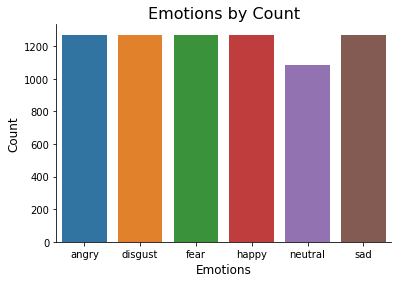

In [4]:
plt.title('Emotions by Count', size=16)
sns.countplot(CREMA_df.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

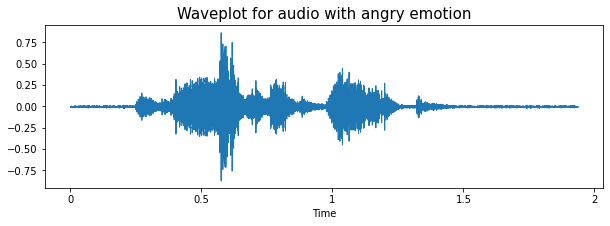

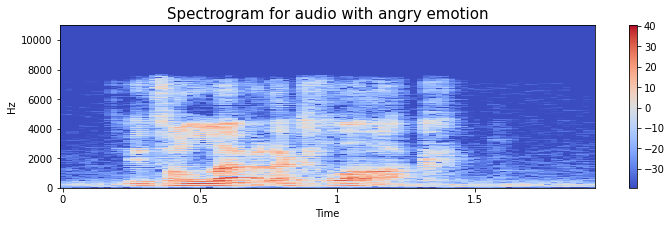

In [6]:
emotion='angry'
path = np.array(CREMA_df.path[CREMA_df.labels==emotion])[1]
data, sample_rate = librosa.load(path)
create_waveplot(data, sample_rate, emotion)
create_spectrogram(data, sample_rate, emotion)
Audio(path)

### Data Augmentation

In [7]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sample_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sample_rate, pitch_factor)

### Feature extraction

In [8]:
def extract_features(data):
    result = np.array([])
    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [9]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2, offset=0.6, sr=8025)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [10]:
X, Y = [], []
for path, emotion in zip(CREMA_df.path, CREMA_df.labels):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Pass sr=8025, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Pass sr=8025, n_steps=0.7 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in a

In [11]:
len(X), len(Y), CREMA_df.path.shape

(22326, 22326, (7442,))

In [12]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,labels
0,0.000327,0.000807,0.001490,0.001556,0.001462,0.001678,0.003553,0.005774,0.015051,0.036686,...,0.001927,0.002279,0.007528,0.008545,0.009004,0.010227,0.001620,0.000423,6.611836e-06,angry
1,0.004473,0.005944,0.007415,0.006263,0.006065,0.007028,0.007419,0.009409,0.025024,0.052293,...,0.006665,0.006215,0.011898,0.012611,0.012462,0.014270,0.005821,0.004857,4.576161e-03,angry
2,0.000095,0.000179,0.000381,0.000415,0.000330,0.000452,0.000851,0.001230,0.003621,0.008427,...,0.001271,0.001030,0.000435,0.001391,0.003079,0.001203,0.000686,0.000072,1.275904e-07,angry
3,0.000465,0.000746,0.000672,0.000618,0.001248,0.002630,0.004533,0.008150,0.024441,0.090599,...,0.003400,0.001376,0.001404,0.001384,0.001166,0.001216,0.000224,0.000026,5.835259e-07,disgust
4,0.001402,0.001273,0.001203,0.001226,0.002345,0.003655,0.005855,0.009221,0.024541,0.090472,...,0.004018,0.002057,0.002036,0.002004,0.001840,0.001887,0.000855,0.000712,7.058120e-04,disgust


### Data Preparation

In [13]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [14]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [15]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 128), (16744, 6), (5582, 128), (5582, 6))

In [16]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 128), (16744, 6), (5582, 128), (5582, 6))

In [17]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16744, 128, 1), (16744, 6), (5582, 128, 1), (5582, 6))

### Modelling

In [18]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=6, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 256)          1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 128)           0

2022-09-07 09:57:24.405804: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50


2022-09-07 09:57:24.722034: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


262/262 [==============================] - 39s 146ms/step - loss: 1.6221 - accuracy: 0.2962 - val_loss: 1.5460 - val_accuracy: 0.3443
Epoch 2/50
262/262 [==============================] - 37s 141ms/step - loss: 1.5266 - accuracy: 0.3608 - val_loss: 1.4801 - val_accuracy: 0.3782
Epoch 3/50
262/262 [==============================] - 37s 141ms/step - loss: 1.5067 - accuracy: 0.3691 - val_loss: 1.4769 - val_accuracy: 0.3821
Epoch 4/50
262/262 [==============================] - 37s 142ms/step - loss: 1.4895 - accuracy: 0.3793 - val_loss: 1.4450 - val_accuracy: 0.4079
Epoch 5/50
262/262 [==============================] - 37s 143ms/step - loss: 1.4681 - accuracy: 0.3934 - val_loss: 1.4197 - val_accuracy: 0.4183
Epoch 6/50
262/262 [==============================] - 38s 143ms/step - loss: 1.4511 - accuracy: 0.4042 - val_loss: 1.4338 - val_accuracy: 0.3979
Epoch 7/50
262/262 [==============================] - 38s 144ms/step - loss: 1.4465 - accuracy: 0.4066 - val_loss: 1.4053 - val_accuracy: 0.4

### Evaluation

175/175 [==============================] - 4s 25ms/step - loss: 1.2327 - accuracy: 0.5321
Accuracy of our model on test data :  53.20673584938049 %


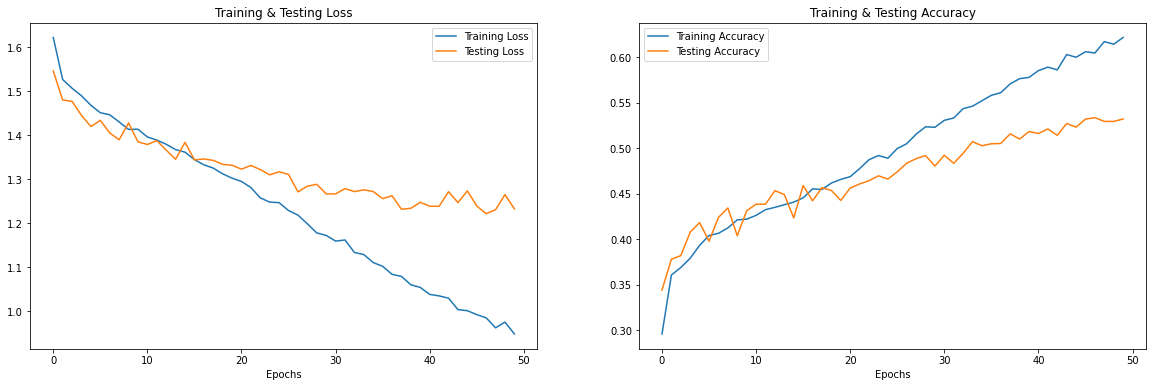

In [20]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [21]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [22]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,happy,happy
2,sad,sad
3,neutral,neutral
4,disgust,disgust
5,neutral,neutral
6,fear,angry
7,sad,sad
8,sad,neutral
9,neutral,sad


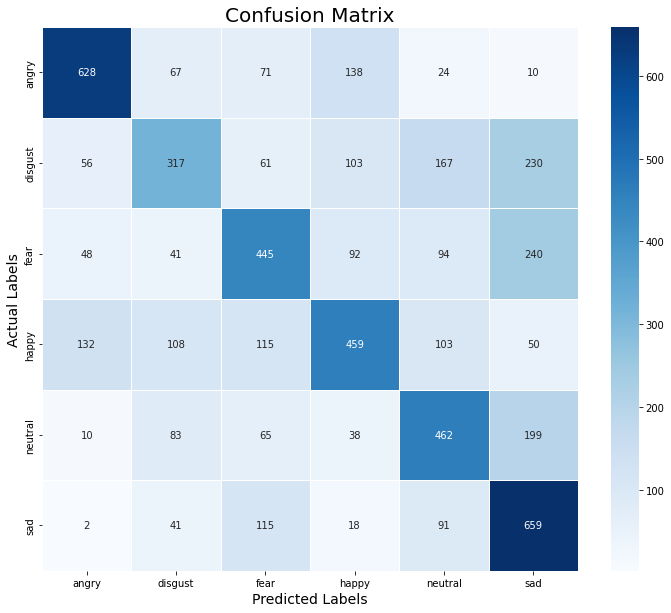

In [23]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.72      0.67      0.69       938
     disgust       0.48      0.34      0.40       934
        fear       0.51      0.46      0.49       960
       happy       0.54      0.47      0.51       967
     neutral       0.49      0.54      0.51       857
         sad       0.47      0.71      0.57       926

    accuracy                           0.53      5582
   macro avg       0.54      0.53      0.53      5582
weighted avg       0.54      0.53      0.53      5582

